# Train Model on Multiple Reservoirs Simultaneously

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing
Process data for each reservoir as usual (conduct train/test/split, fill NaN with training mean, break into chunks, padding remainder) for each reservoir. Then, concat the tensors from each reservoir to form one train, val, and test tensor.

** Note that under this strategy, each reservoir is standardized according to its own training statistics, and not from the entire dataset

Shasta : 1944-01-01 to 2022-12-31 \
Folsom : 1963-01-01 to 2022-12-31 \
New Melones : 1980-01-01 to 2022-12-31 \
Trinity : 1963-01-01 to 2022-12-31

In [3]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False):
    """
    Run data processing pipeline. Return Dataloader objects for training and validation data
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow and doy as input features
    X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [4]:
class multi_reservoir_data:
    """Store and combine data from multiple reservoirs"""
    def __init__(self, left_years_dict):
        """ 
        Params:
        left_years_dict: dict, dictionary of year of first available data from each requested reservoir (name : year)
        """
        self.left_years_dict = left_years_dict

        # Collect train, val, test tensors from each reservoir and their respective src.data.data_processing.time_scaler() objects
        self.X_train_dict = {}
        self.y_train_dict = {}
        self.X_val_dict = {}
        self.y_val_dict = {}
        self.X_test_dict = {}
        self.y_test_dict = {}
        self.scaler_dict = {}
        return
    
    def fetch_data(self):
        """Fetch data for each reservoir and process them into train/val/test tesors"""
        # Run data processing for each reservoir
        for reservoir, left_year in self.left_years_dict.items():
            result = data_processing(name=reservoir, transform_type='standardize', train_frac=0.6, val_frac=0.2, test_frac=0.2,
                                    left=f'{left_year}-01-01', right='2022-12-31',
                                    return_scaler=True)
            # Save results
            self.X_train_dict[reservoir] = result[0][0] # (# chunks, chunk size, # features (e.g. inflow and doy))
            self.y_train_dict[reservoir] = result[0][1] # (# chunks, chunk size, 1 (outflow))
            self.X_val_dict[reservoir] = result[1][0]
            self.y_val_dict[reservoir] = result[1][1]
            self.X_test_dict[reservoir] = result[2][0]
            self.y_test_dict[reservoir] = result[2][1]
            self.scaler_dict[reservoir] = result[3]
        return
    
    def combine_reservoir_data(self):
        """ 
        Concatenate all fetched reservoir data into one train, val, test tensor
        """
        # Concat tensors along chunks dimension (dim = 0)
        X_train, y_train = torch.cat([self.X_train_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_train_dict[key] for key in self.left_years_dict], dim=0)
        X_val, y_val = torch.cat([self.X_val_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_val_dict[key] for key in self.left_years_dict], dim=0)
        X_test, y_test = torch.cat([self.X_test_dict[key] for key in self.left_years_dict], dim=0), torch.cat([self.y_test_dict[key] for key in self.left_years_dict], dim=0)

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def fetch_and_combine(self):
        """Run fetch_data and return combined tensors"""
        self.fetch_data()
        return self.combine_reservoir_data()

In [5]:
# Store first available years for each reservoir
left_years_dict = {'Shasta':1944, 'Folsom':1963, 'New_Melones':1980, 'Trinity':1963}
# Combine data from reservoirs
data_combiner = multi_reservoir_data(left_years_dict=left_years_dict)
data_result = data_combiner.fetch_and_combine()
# Shape of X_train and y_train
data_result[0][0].shape, data_result[0][1].shape

(torch.Size([51, 1095, 2]), torch.Size([51, 1095, 1]))

In [6]:
# Create PyTorch Dataset and Dataloader from training and validation for all reservoirs
dataset_train, dataset_val = (TensorDataset(*data_result[0]), TensorDataset(*data_result[1]))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

## Train Model
Use same hyperparameters as Model 1a as a starting point

In [7]:
# Instantiate model (Model 1a archeticture)
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Run training loop
train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

Training epochs:   6%|▌         | 58/1000 [00:31<08:30,  1.85it/s]


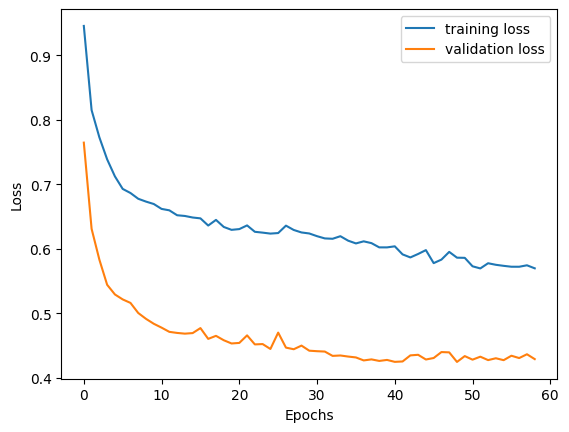

In [9]:
plt.figure()
plot_train_val(train_losses=train_losses, val_losses=val_losses)
plt.show()

In [10]:
# Evaluate performance
# Get predictions
y_hat_train, y_hat_val, y_hat_test = predict(model, data_result[0][0]), predict(model, data_result[1][0]), predict(model, data_result[2][0])
# Flatten and remove padding values
y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=data_result[0][1])
y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=data_result[1][1])
y_hat_test, y_test = flatten_rm_pad(y_hat=y_hat_test, y=data_result[2][1])
# Find and save R2 metrics
r2_train = r2_score(y_pred=y_hat_train, y_true=y_train)
r2_val = r2_score(y_pred=y_hat_val, y_true=y_val)
r2_test = r2_score(y_pred=y_hat_test, y_true=y_test)

print(f"Training R2: {r2_train}, Validation R2: {r2_val}, Testing R2: {r2_test}")

Training R2: 0.45940996760315256, Validation R2: 0.48175181669045697, Testing R2: 0.3607077349699037


### Try model on member reservoirs

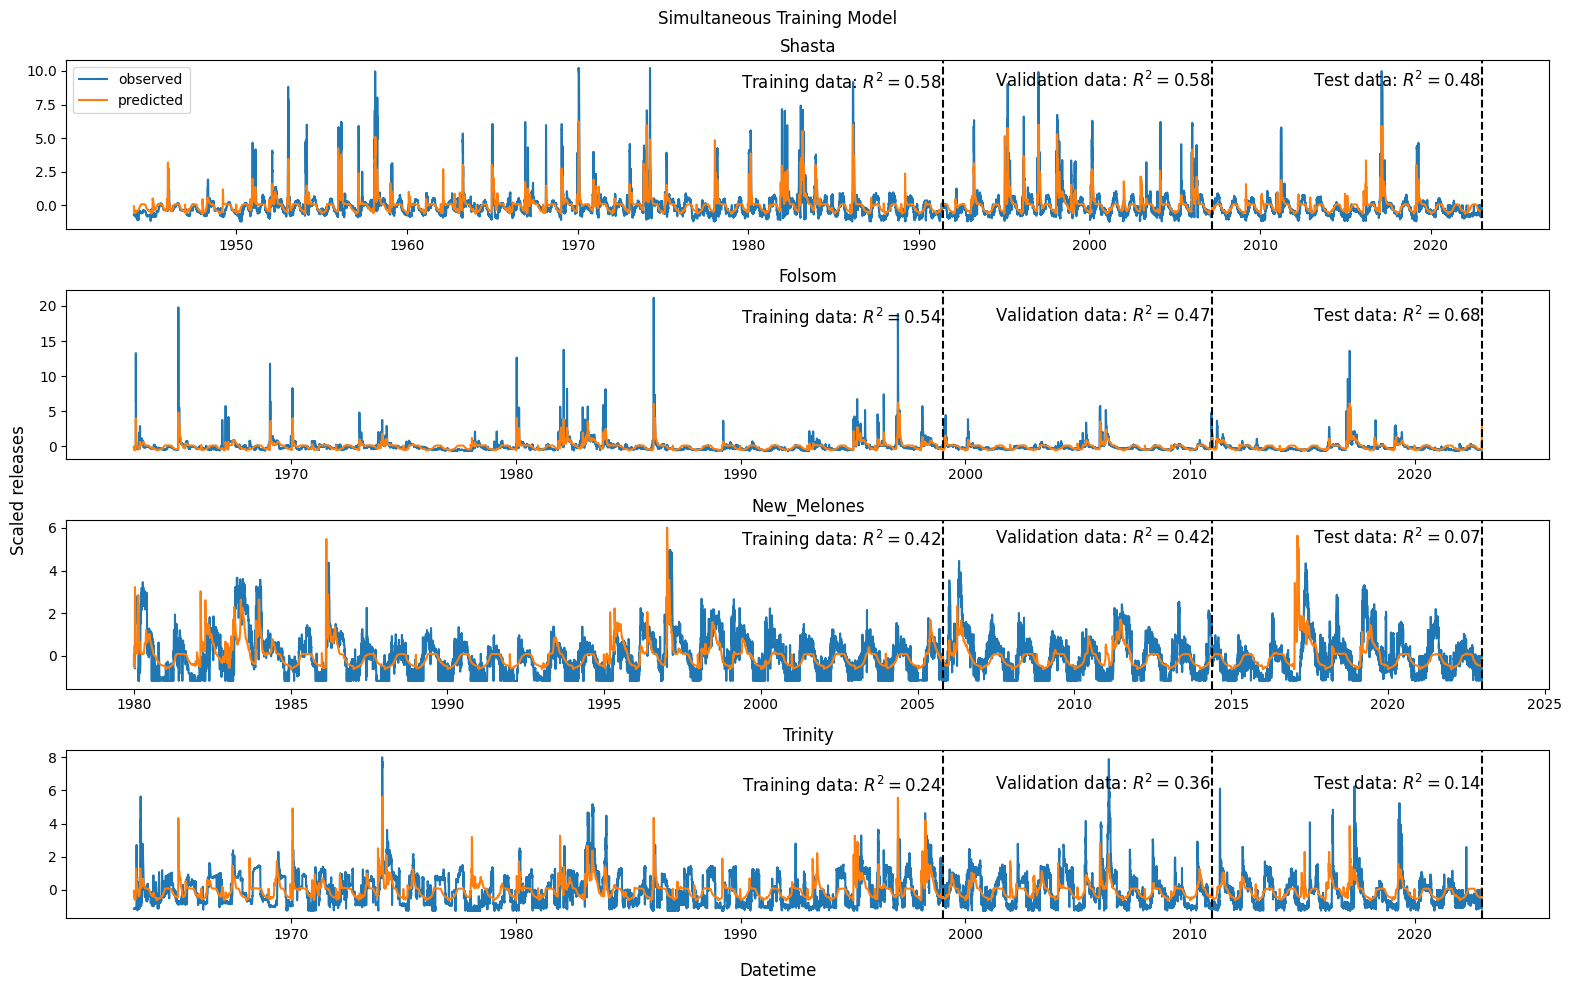

In [11]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=len(left_years_dict))
text_ypos_dict = {'Shasta':10, 'Folsom':20, 'New_Melones':6, 'Trinity':7}

for i, reservoir_key in enumerate(left_years_dict):
    reservoir_left_year = left_years_dict[reservoir_key] # left year window for each reservoir
    plot_and_eval(model, X_train=data_combiner.X_train_dict[reservoir_key], X_val=data_combiner.X_val_dict[reservoir_key], X_test=data_combiner.X_test_dict[reservoir_key],
                y_train=data_combiner.y_train_dict[reservoir_key], y_val=data_combiner.y_val_dict[reservoir_key], y_test=data_combiner.y_test_dict[reservoir_key],
                datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                ax=ax[i], text_ypos=text_ypos_dict[reservoir_key])
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Simultaneous Training Model')
plt.tight_layout()
plt.show()

Overall, performance is worse than when models are fitted to the reservoirs individually. Is this due to the observed difference in reservoir operating behavior?

## Can we finetune the simultaneous model to each particular reservoir?
Initialize model weights to simultaneous model and then conduct finetuning training on a specific reservoir.

In [12]:
class LSTMModel1_finetune(nn.Module):
    """Same architecture as Model 1, but only returns sequence of hidden states and LAST hidden/cell state.
    Uses efficient PyTorch LSTM() layer"""
    def __init__(self, simul_model):
        super(LSTMModel1_finetune, self).__init__()
        self.simul_model = simul_model # larger model trained on all reservoirs

    def forward(self, x):
        # x is (batch size, timesteps, input size)
        self.simul_model.eval()
        out, (h_n, c_n) = self.simul_model(x) # out is (batch size, timesteps, hidden size 1)
        return out, (h_n, c_n)

In [13]:
# Instantiate finetuned models
finetune_model_dict = {}
for reservoir_key in left_years_dict:
    simul_model_copy = copy.deepcopy(model) # copy a version of the simultaneous model
    torch.manual_seed(0)
    finetune_model_dict[reservoir_key] = LSTMModel1_finetune(simul_model=simul_model_copy)

# Save finetuning training losses for each model
finetune_losses_dict = {}

In [14]:
# Run finetuning training loop for each model
for reservoir_key in left_years_dict:
    # Create PyTorch Dataset and Dataloader for each reservoir
    dataset_train_res, dataset_val_res = (TensorDataset(data_combiner.X_train_dict[reservoir_key], data_combiner.y_train_dict[reservoir_key]), 
                                          TensorDataset(data_combiner.X_val_dict[reservoir_key], data_combiner.y_val_dict[reservoir_key]))
    dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                                DataLoader(dataset_val_res, batch_size=1, shuffle=False))
    torch.manual_seed(0)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(finetune_model_dict[reservoir_key].parameters(), lr=0.001)
    # Run training loop (finetune model to shasta)
    train_losses_res, val_losses_res = training_loop(model=finetune_model_dict[reservoir_key], criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_res, 
                                            dataloader_val=dataloader_val_res, epochs=1000)
    finetune_losses_dict[reservoir_key] = (train_losses_res, val_losses_res)

Training epochs:   2%|▏         | 23/1000 [00:02<01:53,  8.62it/s]


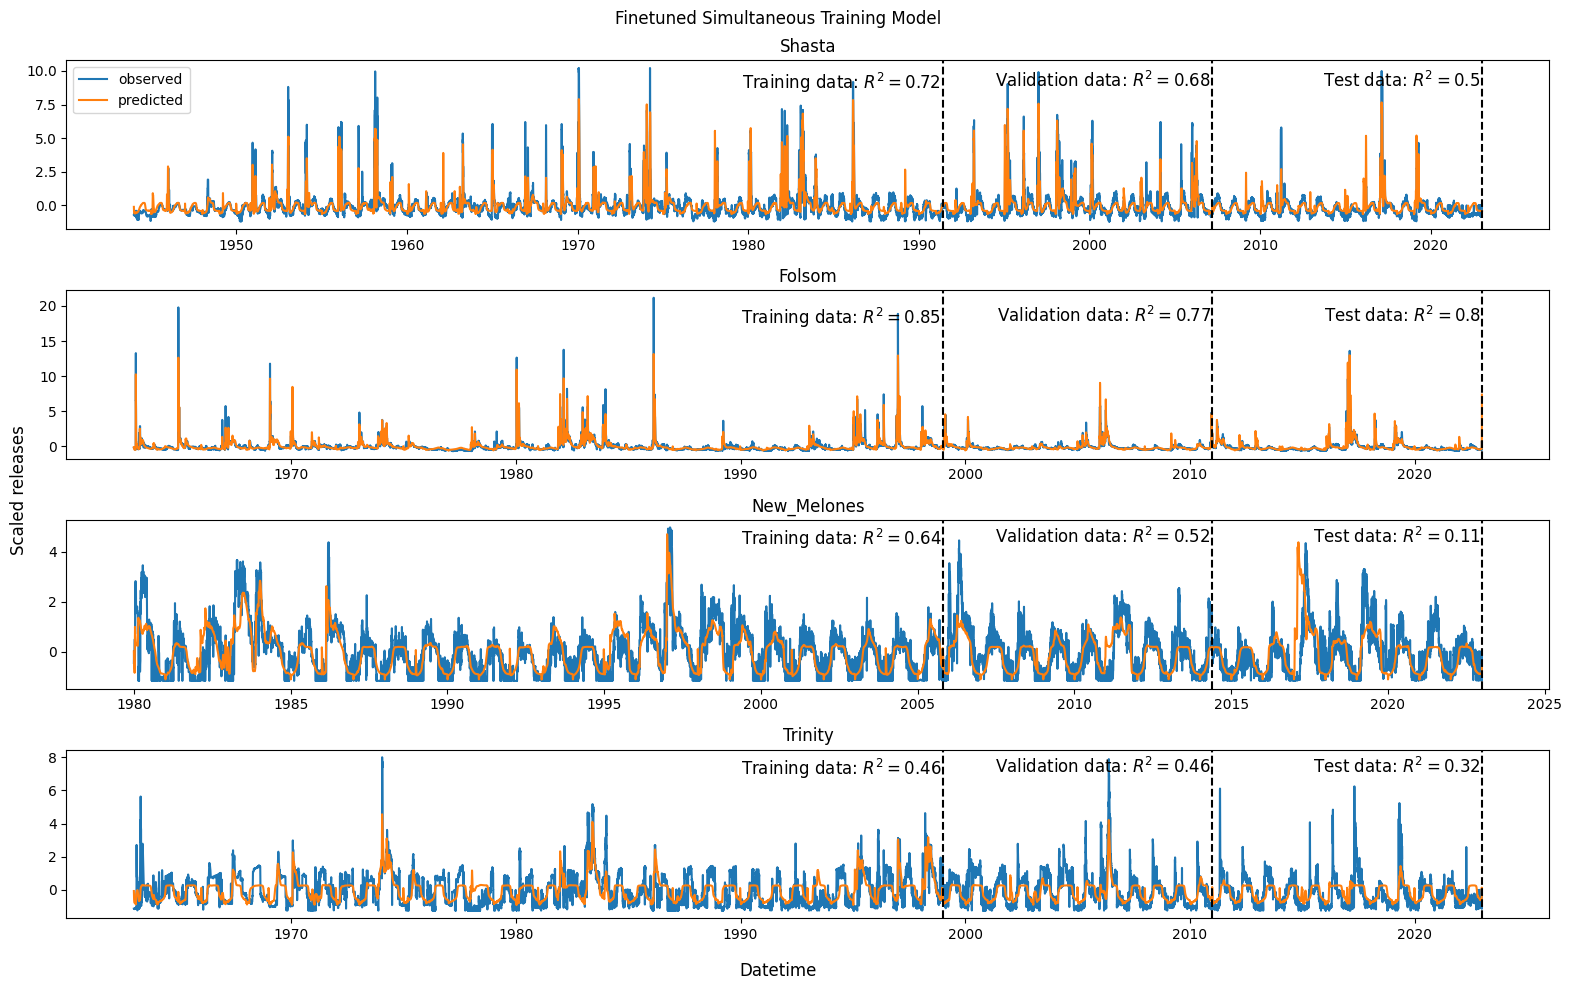

In [15]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=len(left_years_dict))
text_ypos_dict = {'Shasta':10, 'Folsom':20, 'New_Melones':5, 'Trinity':8}

for i, reservoir_key in enumerate(left_years_dict):
    reservoir_left_year = left_years_dict[reservoir_key] # left year window for each reservoir
    plot_and_eval(model=finetune_model_dict[reservoir_key], 
                  X_train=data_combiner.X_train_dict[reservoir_key], X_val=data_combiner.X_val_dict[reservoir_key], X_test=data_combiner.X_test_dict[reservoir_key],
                  y_train=data_combiner.y_train_dict[reservoir_key], y_val=data_combiner.y_val_dict[reservoir_key], y_test=data_combiner.y_test_dict[reservoir_key],
                  datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                  ax=ax[i], text_ypos=text_ypos_dict[reservoir_key])
    
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Finetuned Simultaneous Training Model')
plt.tight_layout()
plt.show()

The finetuned model for Shasta performs essentially the same (slightly better) as Model 1a (trained only with Shasta). Folsom performs similarly to the moving performance experiments, and shows very strong performance. New Melones and Trinity perform better than the moving performance experiments in validation (especially Trinity). For Trinity, test performance is worse than training/validation which suggests that the model from the moving performance experiments was underfit.

## What if we do simulateous training on more similar reservoirs?
We saw previously that some reservoirs (i.e. New Melones, Trinity) do not respond as much to inflow peaks, but other reservoirs such as Shasta and Folsom do. Here, we try simultaneous training for Shasta and Folsom.

In [16]:
# Store first available years for each reservoir
left_years_dict_sim = {'Shasta':1944, 'Folsom':1963}
# Combine data from reservoirs
data_combiner_sim = multi_reservoir_data(left_years_dict=left_years_dict_sim)
data_result_sim = data_combiner_sim.fetch_and_combine()
# Shape of X_train and y_train
data_result_sim[0][0].shape, data_result_sim[0][1].shape

(torch.Size([29, 1095, 2]), torch.Size([29, 1095, 1]))

In [17]:
# Create PyTorch Dataset and Dataloader from training and validation for all reservoirs
dataset_train_sim, dataset_val_sim = (TensorDataset(*data_result_sim[0]), TensorDataset(*data_result_sim[1]))
dataloader_train_sim, dataloader_val_sim = (DataLoader(dataset_train_sim, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val_sim, batch_size=1, shuffle=False))

In [18]:
# Instantiate model (Model 1a archeticture)
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model_sim = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_sim.parameters(), lr=0.001)

In [19]:
# Run training loop
train_losses_sim, val_losses_sim = training_loop(model=model_sim, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train_sim, 
                                        dataloader_val=dataloader_val_sim, epochs=1000)

Training epochs:   2%|▏         | 19/1000 [00:05<04:35,  3.56it/s]


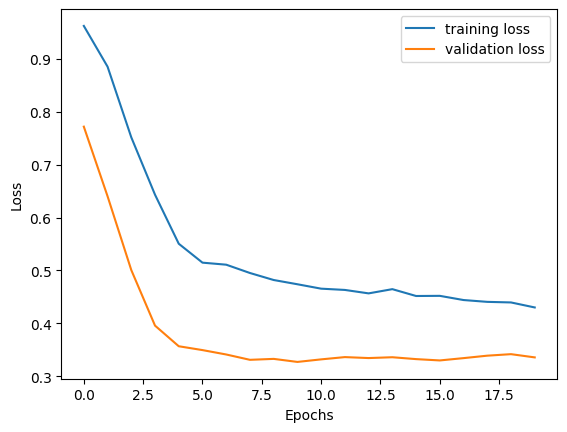

In [21]:
plt.figure()
plot_train_val(train_losses=train_losses_sim, val_losses=val_losses_sim)
plt.show()

In [23]:
# Evaluate performance
# Get predictions
y_hat_train_sim, y_hat_val_sim, y_hat_test_sim = predict(model_sim, data_result_sim[0][0]), predict(model_sim, data_result_sim[1][0]), predict(model_sim, data_result_sim[2][0])
# Flatten and remove padding values
y_hat_train_sim, y_train_sim = flatten_rm_pad(y_hat=y_hat_train_sim, y=data_result_sim[0][1])
y_hat_val_sim, y_val_sim = flatten_rm_pad(y_hat=y_hat_val_sim, y=data_result_sim[1][1])
y_hat_test_sim, y_test_sim = flatten_rm_pad(y_hat=y_hat_test_sim, y=data_result_sim[2][1])
# Find and save R2 metrics
r2_train_sim = r2_score(y_pred=y_hat_train_sim, y_true=y_train_sim)
r2_val_sim = r2_score(y_pred=y_hat_val_sim, y_true=y_val_sim)
r2_test_sim = r2_score(y_pred=y_hat_test_sim, y_true=y_test_sim)

print(f"Training R2: {r2_train_sim}, Validation R2: {r2_val_sim}, Testing R2: {r2_test_sim}")

Training R2: 0.6098187340946868, Validation R2: 0.5769131446877089, Testing R2: 0.555327676719478


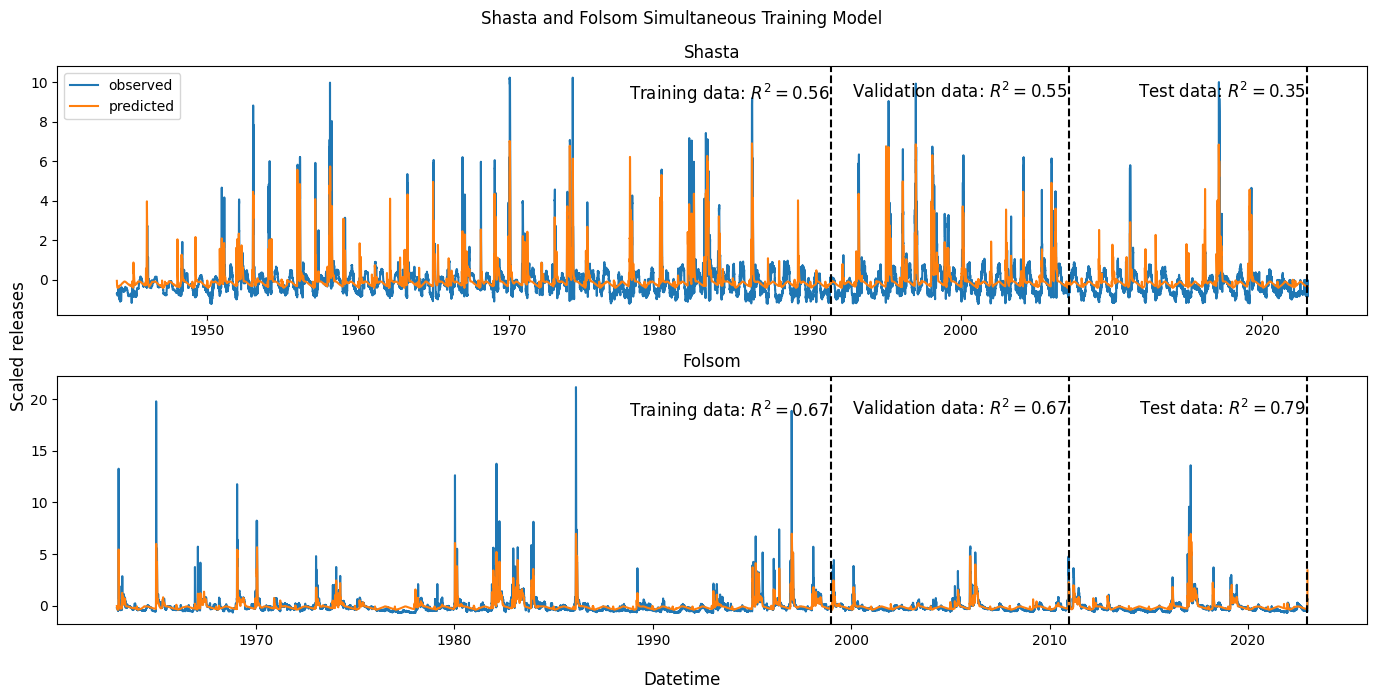

In [28]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=len(left_years_dict_sim))
text_ypos_dict = {'Shasta':10, 'Folsom':20}

for i, reservoir_key in enumerate(left_years_dict_sim):
    reservoir_left_year = left_years_dict_sim[reservoir_key] # left year window for each reservoir
    plot_and_eval(model_sim, X_train=data_combiner_sim.X_train_dict[reservoir_key], X_val=data_combiner_sim.X_val_dict[reservoir_key], X_test=data_combiner_sim.X_test_dict[reservoir_key],
                y_train=data_combiner_sim.y_train_dict[reservoir_key], y_val=data_combiner_sim.y_val_dict[reservoir_key], y_test=data_combiner_sim.y_test_dict[reservoir_key],
                datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                ax=ax[i], text_ypos=text_ypos_dict[reservoir_key])
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Shasta and Folsom Simultaneous Training Model')
plt.tight_layout()
plt.show()

Results are still suboptimal. These results support the hypothesis that each reservoir is operated differently enough so that they cannot be used as iid samples for simultaneous training.

### What if we finetune the Shasta/Folsom model?

In [29]:
# Instantiate finetuned models
finetune_model_dict_sim = {}
for reservoir_key in left_years_dict_sim:
    simul_model_copy = copy.deepcopy(model_sim) # copy a version of the simultaneous model
    torch.manual_seed(0)
    finetune_model_dict_sim[reservoir_key] = LSTMModel1_finetune(simul_model=simul_model_copy)

# Save finetuning training losses for each model
finetune_losses_dict_sim = {}

In [30]:
# Run finetuning training loop for each model
for reservoir_key in left_years_dict_sim:
    # Create PyTorch Dataset and Dataloader for each reservoir
    dataset_train_res, dataset_val_res = (TensorDataset(data_combiner_sim.X_train_dict[reservoir_key], data_combiner_sim.y_train_dict[reservoir_key]), 
                                          TensorDataset(data_combiner_sim.X_val_dict[reservoir_key], data_combiner_sim.y_val_dict[reservoir_key]))
    dataloader_train_res, dataloader_val_res = (DataLoader(dataset_train_res, batch_size=1, shuffle=False), 
                                                DataLoader(dataset_val_res, batch_size=1, shuffle=False))
    torch.manual_seed(0)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(finetune_model_dict_sim[reservoir_key].parameters(), lr=0.001)
    # Run training loop (finetune model to shasta)
    train_losses_res, val_losses_res = training_loop(model=finetune_model_dict_sim[reservoir_key], criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train_res, 
                                            dataloader_val=dataloader_val_res, epochs=1000)
    finetune_losses_dict_sim[reservoir_key] = (train_losses_res, val_losses_res)

Training epochs:   6%|▌         | 62/1000 [00:06<01:45,  8.91it/s]


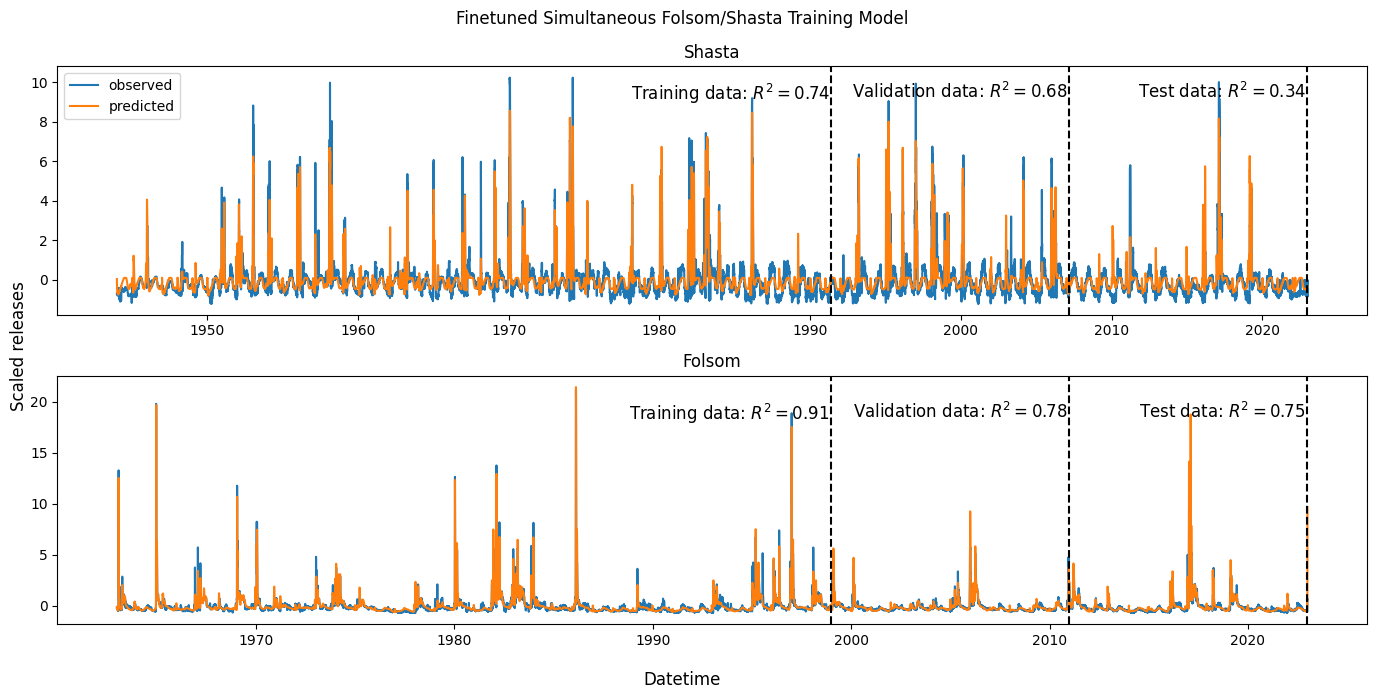

In [31]:
fig, ax = plt.subplots(figsize=(14, 7), nrows=len(left_years_dict_sim))
text_ypos_dict_sim = {'Shasta':10, 'Folsom':20}

for i, reservoir_key in enumerate(left_years_dict_sim):
    reservoir_left_year = left_years_dict_sim[reservoir_key] # left year window for each reservoir
    plot_and_eval(model=finetune_model_dict_sim[reservoir_key], 
                  X_train=data_combiner_sim.X_train_dict[reservoir_key], X_val=data_combiner_sim.X_val_dict[reservoir_key], X_test=data_combiner_sim.X_test_dict[reservoir_key],
                  y_train=data_combiner_sim.y_train_dict[reservoir_key], y_val=data_combiner_sim.y_val_dict[reservoir_key], y_test=data_combiner_sim.y_test_dict[reservoir_key],
                  datetime_index=pd.date_range(start=f'{reservoir_left_year}-01-01', end='2022-12-31', freq='D'),
                  ax=ax[i], text_ypos=text_ypos_dict_sim[reservoir_key])
    
    ax[i].set_title(reservoir_key)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    if i > 0:
        ax[i].get_legend().remove() # turn off legend for all except first axes

fig.supylabel('Scaled releases')
fig.supxlabel('Datetime')
fig.suptitle('Finetuned Simultaneous Folsom/Shasta Training Model')
plt.tight_layout()
plt.show()

There is no apparent advantage in training Shasta and Folsom together or finetuning the trained model.